# Multiscale problem: ``xpektra`` + ``tatva``

In this example, we demonstrate how to solve a multiscale nonlinear elasticity problem using SpectralSolvers. We consider a macroscale domain with microscale heterogeneities and employ a two-scale approach to capture the material behavior accurately.

At the microscale, we use `xpektra` to solve the RVE problem using spectral methods, while at the macroscale, we use `tatva` to solve the global problem using Finite Element Method (FEM).

We couple the two scales by incorporating the microscale response into the macroscale energy functional.

For memory efficiency, we use `jax.checkpoint` to reduce memory consumption during the RVE computations and `custom_linear_solve` to handle the differentiation through linear solves implicitly without unrolling each iteration.

In [1]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
import time

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import Array
from jax_autovmap import autovmap
from skimage.morphology import disk
from tatva import Mesh, Operator, element
from tatva.plotting import plot_nodal_values

from xpektra import FFTTransform, SpectralOperator, SpectralSpace, make_field
from xpektra.projection_operator import GalerkinProjection
from xpektra.scheme import RotatedDifference
from xpektra.solvers.nonlinear import (  # noqa: E402
    conjugate_gradient,
    newton_krylov_solver,
)

## Defining the macroscale problem using Finite Element Method

Now let us see how we can construct the JVP function for a mechanical problem. We will use the same example of a square domain stretched in the $x$-direction.

In [2]:
mesh = Mesh.unit_square(2, 2)

n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

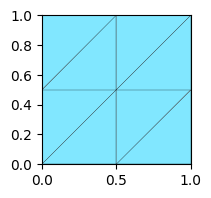

In [3]:
plt.figure(figsize=(2, 2), layout="constrained")
plt.tripcolor(
    *mesh.coords.T,
    mesh.elements,
    facecolors=np.ones(mesh.elements.shape[0]),
    edgecolors="k",
    lw=0.2,
    cmap="managua_r",
)
plt.gca().set_aspect("equal")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

## Defining microscale problem using Spectral methods

We now start with defining the microscale problem using spectral methods. We will use a square domain with periodic boundary conditions and define a two-phase composite material with different elastic moduli.


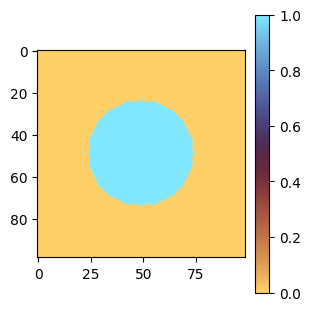

In [4]:
volume_fraction_percentage = 0.2

length = 0.1
H, L = (99, 99)

dx = length / H
dy = length / L

Hmid = int(H / 2)
Lmid = int(L / 2)
vol_inclusion = volume_fraction_percentage * (length * length)
r = (
    int(np.sqrt(vol_inclusion / np.pi) / dx) + 1
)  # Since the rounding off leads to smaller fraction therefore we add 1.


structure = jnp.zeros((H, L))
structure = structure.at[Hmid - r : Hmid + 1 + r, Lmid - r : Lmid + 1 + r].add(disk(r))

ndim = len(structure.shape)
N = structure.shape[0]

plt.figure(figsize=(3, 3), layout="constrained")
plt.imshow(structure, cmap="managua")
plt.colorbar()
plt.show()

The material properties are defined as follows:

In [6]:
lambda_solid = 10
mu_solid = 0.25

lambda_inclusion = 1.0
mu_inclusion = 2.5

lambda_field = lambda_solid * (1 - structure) + lambda_inclusion * structure
mu_field = mu_solid * (1 - structure) + mu_inclusion * structure

We can define our transform method to the spectral space, differential scheme, and projection operator.

For this example, we will use a Rotated difference scheme, and a Galerkin projection.

As in `xpektra`, we can define the spectral operator that enscapes the spectral transform, differential scheme, and tensor operations.

In [7]:
fft_transform = FFTTransform(dim=ndim)
space = SpectralSpace(
    lengths=(length,) * ndim, shape=structure.shape, transform=fft_transform
)
diff_scheme = RotatedDifference(space=space)

spec_op = SpectralOperator(
    scheme=diff_scheme,
    space=space,
)

dofs_shape = make_field(dim=2, shape=structure.shape, rank=2).shape

Ghat = GalerkinProjection(scheme=diff_scheme)

## Using `checkpoint` and `custom_linear_solve` for memory-efficient RVE

To ease the implementation and handling of RVEs, we define a helper class `RVEMaterial` that will hold the RVE properties and methods to compute the residual and JVP and macroscale stresses from macroscale strains.

A key point to note here is that the function `compute_macros_stress` is decorated with `jax.checkpoint`. This is done to avoid storing the entire computational graph during the forward pass, which can lead to high memory consumption. By using `jax.checkpoint`, we can trade off some computational time for reduced memory usage, which is particularly beneficial when dealing with large-scale problems or complex models. In simple terms, it tells JAX:

"_During the forward pass, just run this function and store only its final output. During the backward pass (for the gradient), don't look up the stored history—just re-run the entire function from scratch to get the values you need._"


Another important aspect is the custom `conjugate_gradient` which uses `jax.lax.custom_linear_solve` to define a linear solver with a implicit differentiation. This allows JAX to not unroll the entire CG iterations during backpropagation, leading to significant memory savings. Basically, on the backward pass, JAX knows that to get the gradient, it just needs to call the transpose_solve function to solve the adjoint system $A^T\lambda=g$ at the converged solution, without needing to remember all the intermediate steps of the CG iterations.


In [8]:
class RVEMaterial(eqx.Module):
    """A simple linear elastic material model."""

    mu: Array
    lmbda: Array
    dofs_shape: tuple = eqx.field(static=True)

    @eqx.filter_jit
    def compute_strain_energy(self, eps_flat: Array) -> Array:
        eps = eps_flat.reshape(self.dofs_shape)
        eps_sym = 0.5 * (eps + spec_op.trans(eps))
        energy = 0.5 * jnp.multiply(
            self.lmbda, spec_op.trace(eps_sym) ** 2
        ) + jnp.multiply(self.mu, spec_op.trace(spec_op.dot(eps_sym, eps_sym)))
        return energy.sum()

    @eqx.filter_jit
    def compute_rve_stress(self, eps_flat: Array) -> Array:
        return jax.jacrev(self.compute_strain_energy)(eps_flat)

    @eqx.filter_jit
    def jacobian(self, eps_flat: Array) -> Array:
        """
        This makes instances of this class behave like a function.
        It takes only the flattened vector of unknowns, as required by the solver.
        """
        eps_flat = eps_flat.reshape(-1)
        sigma = self.compute_rve_stress(eps_flat)
        residual_field = spec_op.inverse(
            Ghat.project(spec_op.forward(sigma.reshape(self.dofs_shape)))
        )
        return jnp.real(residual_field).reshape(-1)

    @eqx.filter_jit
    def hessian(self, deps_flat: Array) -> Array:
        """
        The Jacobian is a linear operator, so its __call__ method
        represents the Jacobian-vector product.
        """

        deps_flat = deps_flat.reshape(-1)
        dsigma = self.compute_rve_stress(deps_flat)
        jvp_field = spec_op.inverse(
            Ghat.project(spec_op.forward(dsigma.reshape(self.dofs_shape)))
        )
        return jnp.real(jvp_field).reshape(-1)

    # @partial(jax.checkpoint, static_argnums=(0,))
    @eqx.filter_jit
    def compute_macro_stress(self, macro_strain):
        # set macroscopic loading
        DE = jnp.array(make_field(dim=2, shape=structure.shape, rank=2))
        DE = DE.at[:, :, 0, 0].set(macro_strain[0, 0])
        DE = DE.at[:, :, 1, 1].set(macro_strain[1, 1])
        DE = DE.at[:, :, 0, 1].set(macro_strain[0, 1])
        DE = DE.at[:, :, 1, 0].set(macro_strain[1, 0])

        # initial residual: distribute "DE" over grid using "K4"
        b = -self.jacobian(DE)

        eps = newton_krylov_solver(
            x=DE,
            b=b,
            gradient=self.jacobian,
            jacobian=self.hessian,
            tol=1e-8,
            max_iter=20,
            krylov_solver=conjugate_gradient,
            krylov_tol=1e-8,
            krylov_max_iter=20,
        )

        rve_sig = self.compute_rve_stress(eps)

        # get the macro stress
        macro_sigma = jnp.sum(rve_sig * dx * dy, axis=(0, 1)) / (length**2)

        del rve_sig

        return macro_sigma

    def compute_tangent(self, macro_strain):
        tangent = jax.jacfwd(self.compute_macro_stress)
        return tangent(macro_strain)

Now  we can define our rve material with the defined structure and material properties.

In [9]:
rvematerial = RVEMaterial(mu=mu_field, lmbda=lambda_field, dofs_shape=dofs_shape)

## Defining the energy functional at macroscale
We now define the total energy functional at the macroscale. This functional computes the total energy of the system given the macroscale strain and macroscale stress computed from the RVE material.

$$
\Psi_\text{macro} =\int \frac{1}{2} \sigma(\varepsilon_\text{macro}) : \varepsilon_\text{macro} ~d\text{V}
$$

where $\sigma(\varepsilon_\text{macro})$ is the macroscale stress computed from the RVE material given the macroscale strain $\varepsilon_\text{macro}$. T To compute the $\sigma(\varepsilon_\text{macro})$ we make use of the homogenized tangent computed from the RVE material.

$$
\sigma(\varepsilon_\text{macro}) = \mathbb{C}_\text{macro} : \varepsilon_\text{macro}
$$


the macroscale strain is computed from the macroscale displacement gradient.

$$
\varepsilon_\text{macro} = \frac{1}{2} (\nabla u + \nabla u^T)
$$

In [20]:

tri = element.Tri3()
op = Operator(mesh, tri)


@autovmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.T)


@autovmap(grad_u=2)
def strain_energy(grad_u: Array) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    tangent = rvematerial.compute_tangent(eps)
    sig = jnp.einsum("ijkl, kl->ij", tangent, eps)
    return 0.5 * jnp.einsum("ij,ij->", sig, eps)


@jax.jit
def total_energy(u_flat):
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_grad = op.grad(u)
    energy_density = strain_energy(u_grad)
    return op.integrate(energy_density)


gradient = jax.jacrev(total_energy)

@eqx.filter_jit
def compute_gradient(u):
    u_flat = u.reshape(-1)
    grad = gradient(u_flat)
    return grad, grad

gradient_with_hessian = jax.jacfwd(compute_gradient, has_aux=True)

The above was coupling the macroscale and microscale. The use of JAX's automatic differentiation and custom linear solvers allows us to efficiently compute the necessary derivatives necessary for linking the two scales together.

We can now solve the macroscale problem for a given set of boundary conditions and loading using the defined energy functional and the RVE material.

In [21]:
left_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 0.0))[0]
right_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 1.0))[0]
fixed_dofs = jnp.concatenate(
    [
        2 * left_nodes,
        2 * left_nodes + 1,
        2 * right_nodes,
    ]
)
prescribed_values = jnp.zeros(n_dofs).at[2 * right_nodes].set(0.3)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

## Using Newton's method at macroscale

At macroscale we use Newton's method with the Newton-Raphson method with a direct linear solver to solve the linearized system at each Newton iteration.
Below we define the Newton solver. The boundary conditions are applied at each iteration using the lifting approach.

In [22]:


def newton_solver(
    u,
    fext,
    fixed_dofs,
):
    K, fint = gradient_with_hessian(u)

    du = jnp.zeros_like(u)

    iiter = 0
    norm_res = 1.0

    tol = 1e-8
    max_iter = 10

    while norm_res > tol and iiter < max_iter:
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)

        print("assembling linear system")

        #K = hessian(u)
        K_lifted = K.at[jnp.ix_(free_dofs, fixed_dofs)].set(0.0)
        K_lifted = K_lifted.at[jnp.ix_(fixed_dofs, free_dofs)].set(0.0)
        K_lifted = K_lifted.at[jnp.ix_(fixed_dofs, fixed_dofs)].set(
            jnp.eye(len(fixed_dofs))
        )
        du = jnp.linalg.solve(K_lifted, residual)

        u = u.at[:].add(du)
        K, fint = gradient_with_hessian(u)
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)
        norm_res = jnp.linalg.norm(residual)
        print(f"Macroscale  Residual: {norm_res:.2e}")
        iiter += 1

    return u, norm_res

## Solving the macroscale problem

We can now solve the macroscale problem using Newton's method with the newton raphson method with a direct linear solver.

In [23]:
u = jnp.zeros(n_dofs)
fext = jnp.zeros(n_dofs)

n_steps = 1

du_total = prescribed_values / n_steps  # displacement increment


start_time = time.time()

for step in range(n_steps):
    print(f"Step {step + 1}/{n_steps}")
    u = u.at[fixed_dofs].set((step + 1) * du_total[fixed_dofs])

    u_new, rnorm = newton_solver(
        u,
        fext,
        fixed_dofs,
    )

    u = u_new


u = u.at[fixed_dofs].set(prescribed_values.at[fixed_dofs].get())

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

u_solution = u.reshape(n_nodes, n_dofs_per_node)
print("Final displacement field:\n", u_solution)

Step 1/1
Converged, Residual value : 8.35888085015558e-09
Converged, Residual value : 0.0
Didnot converge, Residual value : 8.35888085015558e-09
Didnot converge, Residual value : 8.35888085015558e-09
Converged, Residual value : 8.35888085015558e-09
Converged, Residual value : 8.35888085015558e-09
Converged, Residual value : 0.0
Didnot converge, Residual value : 0.0
Didnot converge, Residual value : 0.0
Didnot converge, Residual value : 8.35888085015558e-09
Converged, Residual value : 0.0
Converged, Residual value : 0.0
Converged, Residual value : 8.35888085015558e-09
Didnot converge, Residual value : 0.0
Didnot converge, Residual value : 0.0
Didnot converge, Residual value : 8.35888085015558e-09
assembling linear system
Didnot converge, Residual value : 8.21943687854892e-09
Converged, Residual value : 9.703063929747395e-09
Converged, Residual value : 8.951874271943062e-09
Converged, Residual value : 7.283241686478165e-09
Didnot converge, Residual value : 9.703063929747395e-09
Didnot co

## Post-processing

Now we can plot the displacement at the macroscale.



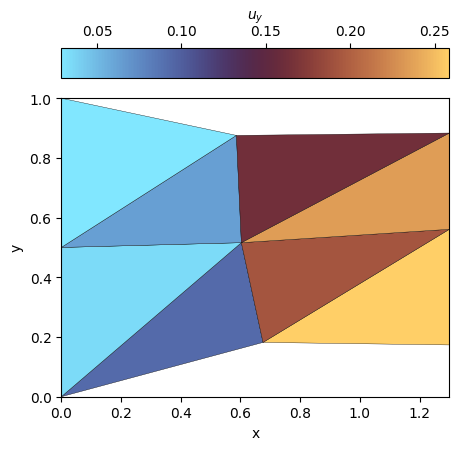

In [24]:
fig = plt.figure(figsize=(6, 4), layout="constrained")
ax = plt.axes()

plot_nodal_values(
    coords=mesh.coords,
    elements=mesh.elements,
    values=u_solution[:, 0].flatten(),
    u=u_solution,
    ax=ax,
    label=r"$u_y$",
    shading="flat",
    edgecolors="black",
)
ax.set_xlabel(r"x")
ax.set_ylabel(r"y")
ax.set_aspect("equal")

ax.margins(0, 0)
plt.show()